In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


In [0]:
import os
from PIL import Image
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
import cv2
import scipy.misc
from skimage import transform
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings

warnings.filterwarnings("ignore")

##Global variable
IMAGE_SIZE = 66

**Loading Data**

In [0]:
data_dir = '/content/drive/My Drive/Colab/plant-seedlings-classification'

In [0]:
#convertering list of training data paths to dataframe
train_dir = '/content/drive/My Drive/Colab/plant-seedlings-classification/train/'
species = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen',
          'Loose Silky-bent', 'Maize','Scentless Mayweed', 'Shepherds Purse',
          'Small-flowered Cranesbill', 'Sugar beet']

In [0]:
# Organize training files into DataFrame
train_data = []
for species_id, sp in enumerate(species):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['train/{}/{}'.format(sp, file), species_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'SpeciesId','Species'])
train.head()

,File,SpeciesId,Species
0,train/Black-grass/d8afd58f3.png,0,Black-grass
1,train/Black-grass/eac39cfa8.png,0,Black-grass
2,train/Black-grass/bc68a27f9.png,0,Black-grass
3,train/Black-grass/4f48eb987.png,0,Black-grass
4,train/Black-grass/a8ab1ff26.png,0,Black-grass


In [0]:
train.tail()

,File,SpeciesId,Species
4775,train/Sugar beet/292e00e4d.png,11,Sugar beet
4776,train/Sugar beet/cc285d141.png,11,Sugar beet
4777,train/Sugar beet/748fd9df6.png,11,Sugar beet
4778,train/Sugar beet/d9f0ac9a7.png,11,Sugar beet
4779,train/Sugar beet/9ee5dbda4.png,11,Sugar beet


In [0]:
train.shape

(4780, 3)

In [0]:
# Randomize the order of training set
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset index
train.head()

,File,SpeciesId,Species
0,train/Loose Silky-bent/b01d0bbea.png,6,Loose Silky-bent
1,train/Loose Silky-bent/3f13f9bae.png,6,Loose Silky-bent
2,train/Loose Silky-bent/d62f8f844.png,6,Loose Silky-bent
3,train/Common Chickweed/c88a5b482.png,3,Common Chickweed
4,train/Common Chickweed/965f8a9c2.png,3,Common Chickweed


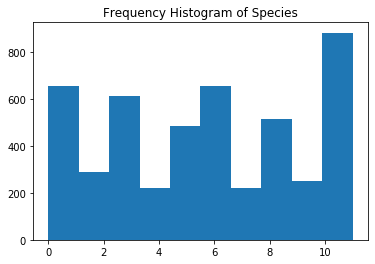

<Figure size 1080x1080 with 0 Axes>

In [0]:
# Plot a histogram
plt.hist(train['SpeciesId'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(15, 15))
plt.show()

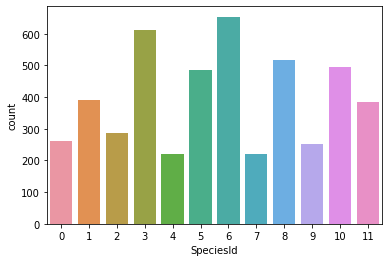

In [0]:
#plotting how the classes are distributed
sns.countplot(train['SpeciesId'])

**Plotting training images**

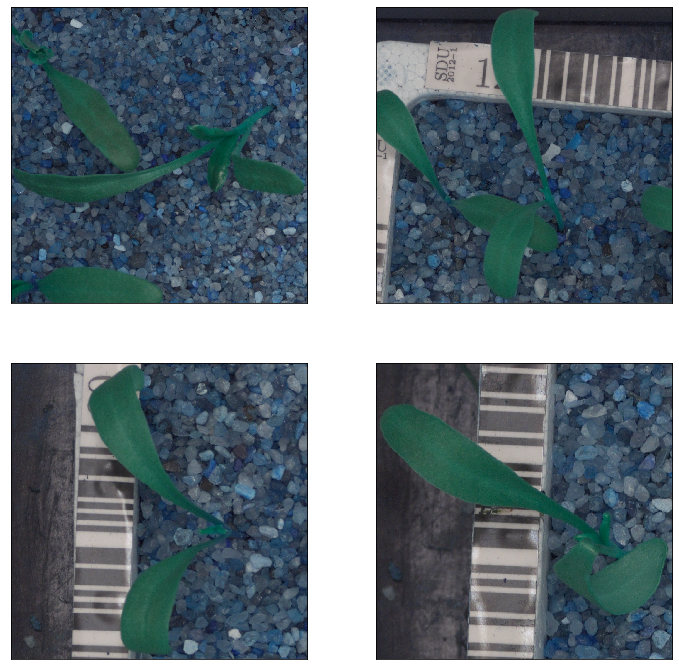

In [0]:
# Display images for different species
def plot_species(species, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    species_files = train['File'][train['Species'] == species].values
    n = 0
    #print(species_files)
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, species_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1

plot_species('Sugar beet', 2, 2)

In [0]:
train[train['Species']=='Sugar beet'].head()

,File,SpeciesId,Species
6,train/Sugar beet/f9a842f5f.png,11,Sugar beet
11,train/Sugar beet/7b4682569.png,11,Sugar beet
28,train/Sugar beet/d41a8cb93.png,11,Sugar beet
40,train/Sugar beet/da2912b2f.png,11,Sugar beet
42,train/Sugar beet/4b8daeba3.png,11,Sugar beet


**Image segmentation and plotting**

In [0]:
# Image segmentation
def create_mask(image):
    # Convert from BGR to HSV color-space to extract colored object
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Define range of green in HSV
    lower_green = np.array([30, 100, 50])
    upper_green = np.array([85, 255, 255])
    # Threshold the HSV image to get only green colors
    mask = cv2.inRange(image_hsv, lower_green, upper_green)
    # We will use a morphological operation called closing to close small holes in the image
    # We need a kernel or structuring element to determine the nature of the operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

def segment_image(image):
    mask = create_mask(image)
    res = cv2.bitwise_and(image, image, mask=mask) # Bitwise-AND mask and original image
    return res

def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

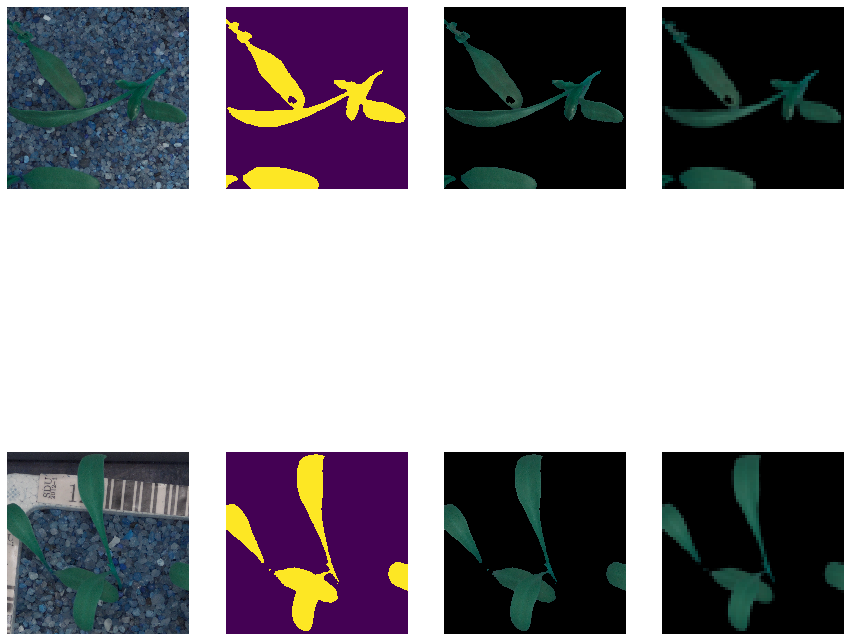

In [0]:
def show_segmented_images(species, n):
    fig, ax = plt.subplots(n, 4, figsize=(15, 15))
    species_files = train['File'][train['Species'] == species].values
    for i in range(n):
        image = read_image(species_files[i])
        image_masked = create_mask(image)
        image_segmented = segment_image(image)
        image_resized = resize_image(image_segmented, (IMAGE_SIZE, IMAGE_SIZE))
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()
        ax[i, 3].set_axis_off()
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(image_masked)
        ax[i, 2].imshow(image_segmented)
        ax[i, 3].imshow(image_resized)

show_segmented_images('Sugar beet', 2)

**Reshaping the image to extract features**

In [0]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    image_segmented = segment_image(image)
    X_train[i] = resize_image(image_segmented, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_train = X_train / 255.
print('Train Shape: {}'.format(X_train.shape))

4780it [01:07, 71.09it/s] 

Train Shape: (4780, 66, 66, 3)


Encoding target's

In [0]:
Y_train = train['SpeciesId'].values
from keras.utils import to_categorical
Y_train = tf.keras.utils.to_categorical(Y_train, num_classes=12)

Using TensorFlow backend.


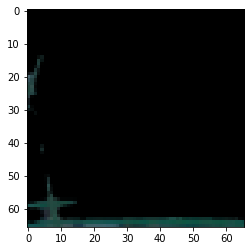

In [0]:
plt.imshow(X_train[0])

Saving the image data into a pickle file for easy retrieval

In [0]:
import pickle
pickle_out = open("/content/drive/My Drive/Colab/plant-seedlings-classification/x_train.pickle","wb")
pickle.dump(X_train,pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Colab/plant-seedlings-classification/Y_train.pickle","wb")
pickle.dump(Y_train,pickle_out)
pickle_out.close()

In [0]:
pickle_in = open("/content/drive/My Drive/Colab/plant-seedlings-classification/x_train.pickle","rb")
x_trainnew = pickle.load(pickle_in) 
print(x_trainnew.shape)
pickle_in.close()

(4780, 66, 66, 3)


In [0]:
pickle_in = open("/content/drive/My Drive/Colab/plant-seedlings-classification/Y_train.pickle","rb")
Y_trainnew = pickle.load(pickle_in) 
print(Y_trainnew[1])
pickle_in.close()

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [0]:
BATCH_SIZE = 16
EPOCHS = 75
num_classes = 12

X_train, X_val, Y_train, Y_val = train_test_split(x_trainnew, Y_trainnew, test_size=0.1, random_state=SEED)

In [0]:
def construct_model():
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5),input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(axis=3))
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.BatchNormalization(axis=3))
    model.add(tf.keras.layers.Dropout(0.1))

    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(axis=3))
    model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.BatchNormalization(axis=3))
    model.add(tf.keras.layers.Dropout(0.1))

    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(axis=3))
    model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.BatchNormalization(axis=3))
    model.add(tf.keras.layers.Dropout(0.1))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.summary()
    return model

In [0]:
def train_model():
    model = construct_model()
    checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Colab/plant-seedlings-classification/model.h5', verbose=1, save_best_only=True)
    # Generates batches of image data with data augmentation
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                            width_shift_range=0.2, # Range for random horizontal shifts
                            height_shift_range=0.2, # Range for random vertical shifts
                            zoom_range=0.2, # Range for random zoom
                            horizontal_flip=True, # Randomly flip inputs horizontally
                            vertical_flip=True) # Randomly flip inputs vertically
    
    datagen.fit(X_train)
    # Fits the model on batches with real-time data augmentation
    hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
                   steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
                   epochs=EPOCHS,
                   verbose=2,
                   callbacks=[checkpoint],
                   validation_data=(X_val, Y_val))

In [0]:
train_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 58, 58, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 29, 29, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       2

In [0]:
final_model = tf.keras.models.load_model('/content/drive/My Drive/Colab/plant-seedlings-classification/model.h5')
final_loss, final_accuracy = final_model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

478/478 [==============================] - 0s 769us/sample - loss: 0.3275 - accuracy: 0.8912
Final Loss: 0.32745559295351034, Final Accuracy: 0.8912134170532227


Text(0.5, 145.31999999999996, 'Predicted')

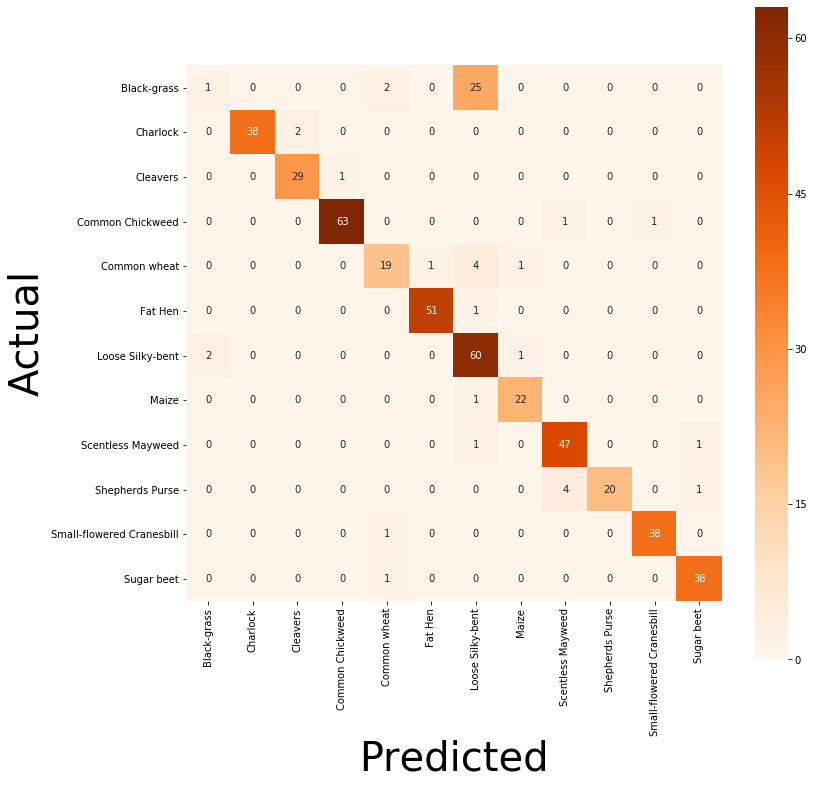

In [0]:
Y_pred = final_model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Oranges, annot=True, square=True, xticklabels=species, yticklabels=species)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [0]:
print(classification_report(Y_true, Y_pred))

              precision    recall  f1-score   support

           0       0.33      0.04      0.06        28
           1       1.00      0.95      0.97        40
           2       0.94      0.97      0.95        30
           3       0.98      0.97      0.98        65
           4       0.83      0.76      0.79        25
           5       0.98      0.98      0.98        52
           6       0.65      0.95      0.77        63
           7       0.92      0.96      0.94        23
           8       0.90      0.96      0.93        49
           9       1.00      0.80      0.89        25
          10       0.97      0.97      0.97        39
          11       0.95      0.97      0.96        39

    accuracy                           0.89       478
   macro avg       0.87      0.86      0.85       478
weighted avg       0.88      0.89      0.87       478



**Looks like black-grass and loose silky-bent species images are looking quite similar to each other so the CNN is making errors.**

# Summary :

* Loaded the train dataset folder to read the images and assigned the species for each image

* Performed segmentation to remove background/noise and resized the images.

* Built a sequential neural network model and trained them after image augumentation.

* Validated the model against the validation data set.

* The model performed well drawing out 89% accuracy.